In [1]:
%%capture
!pip install mujoco==2.3.3


## **Importing Required Libraries**

This cell imports all the necessary libraries for implementing **Proximal Policy Optimization (PPO)**. The key components include:

In [3]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal, Normal
import torch.nn.functional as F

import torch.optim as optim
import gymnasium as gym
import numpy as np
import os
import pandas as pd

import imageio
from base64 import b64encode
from IPython.display import HTML


import logging
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()

if is_ipython:
    from IPython import display


## **Logging, Visualization, and Video Playback Functions**


In [4]:
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## **Memory Buffer for PPO**

### **Class: `Memory`**
- A **buffer** for storing experiences during training, used for **PPO (Proximal Policy Optimization) updates**.
- Stores the following per episode:
  - `actions`: Actions taken by the agent.
  - `states`: Observed states from the environment.
  - `logprobs`: Log probabilities of actions (needed for importance sampling in PPO).
  - `rewards`: Rewards obtained after taking actions.
  - `state_values`: Estimated state values from the critic.

### **Function: `clear()`**
- Clears the stored experiences before collecting new trajectories.
- Ensures memory is reset between updates to prevent stale data from affecting optimization.


In [5]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]

## **Actor-Critic Network in PPO**

This implementation defines two neural networks used in Proximal Policy Optimization (PPO).

The actor network is responsible for predicting a probability distribution over actions (discrete) or estimating the value for each action (continuous), given the current state, while the critic network evaluates how good the action taken by the actor is, by predicting the reward based on state.

In [7]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu_head = nn.Linear(hidden_size, action_dim)
        self.sigma_head = nn.Parameter(torch.zeros(1,action_dim))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu_head(x)
        std = torch.exp(self.sigma_head.expand_as(mu))
        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.value_head = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.value_head(x)
        return value

## **Proximal Policy Optimization (PPO) Algorithm Implementation**

This class implements the **PPO (Proximal Policy Optimization) algorithm**, which is a policy gradient method used in reinforcement learning. It optimizes an actor-critic network while maintaining stability and efficiency.

### **Key Components:**
1. **Initialization (`__init__`)**:
   - Sets hyperparameters (e.g., `gamma`, `eps_clip`, `gae_lambda`).
   - Creates **Actor and Critic networks**.
   - Defines **Adam optimizers** for both networks.
   - Initializes a memory buffer for storing experience.

2. **Action Selection (`select_action`)**:
   - Uses the **Actor network** to predict a mean and standard deviation for the action.
   - Samples an action from a normal distribution.
   - Stores the action, log probability, and value function output in memory.

3. **Policy Evaluation (`evaluate`)**:
   - Computes the log probability of actions under the current policy.
   - Returns entropy (used for exploration encouragement).

4. **Policy Update (`update`)**:
   - Computes **discounted rewards** and **Generalized Advantage Estimation (GAE)**.
   - Uses **clipped surrogate objective** to stabilize training.
   - Minimizes **actor loss** (policy update) and **critic loss** (value function update).
   - Updates networks using **gradient descent**.

5. **Memory Handling (`push_memory`, `load_memory`, `store_reward`)**:
   - Stores and retrieves experience for training updates.
   - Resets the memory buffer after each policy update.

### **Key Features of PPO**
- **Clipping Ratio**: Prevents excessive updates to the policy, improving stability.
- **Advantage Estimation**: Helps in reducing variance in policy updates.
- **Entropy Regularization**: Encourages exploration by adding entropy loss.


## **1. PPO Clipped Loss Function**
The PPO loss function prevents large policy updates by introducing a clipped objective. The ratio of new and old policy probabilities is computed as:
$$
r_t(\theta) = \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$
where:
- $ \theta $ are the current policy parameters.
- $\theta_{\text{old}} $ are the policy parameters before the update.

The surrogate loss function is:
$$
L^{\text{CLIP}}(\theta) = \mathbb{E} \left[ \min \left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$
where:
- $ A_t $ is the **advantage function**, which measures how much better an action is compared to the expected value of the state.
- $ \epsilon $ is a small clipping parameter (e.g., **0.2**) that prevents drastic policy updates.

---

## **2. Critic Loss Function**
The critic is updated using **Mean Squared Error (MSE)** between the predicted and actual state value:
$$
L_{\text{critic}} = \mathbb{E} \left[ (V(s_t) - R_t)^2 \right]
$$

---

## **3. Total Loss**
The overall loss function is:
$$
L_{\text{total}} = L^{\text{CLIP}} + \beta H - L_{\text{critic}}
$$
where:
- $ H $ is the **entropy bonus** to encourage exploration.
- $ \beta $ is a small coefficient (e.g., **0.01**) controlling the strength of the entropy bonus.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

class PPO(nn.Module):
    def __init__(self, env, config):
        super(PPO, self).__init__()

        # Hyperparameters
        self.gamma = config.GAMMA
        self.eps_clip = config.EPS_CLIP
        self.epochs = config.K_EPOCHS
        self.gae_lambda = config.GAE
        self.hidden_size = config.hidden_size
        self.lr = config.LEARNING_RATE

        # Environment dimensions
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        # Actor and Critic Networks
        self.actor = Actor(state_dim, self.hidden_size, action_dim).to(device)
        self.critic = Critic(state_dim, self.hidden_size).to(device)

        # Optimizers
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr)

        # Memory buffer
        self.memory = Memory()

    def select_action(self, state):
        """
        Selects an action using the actor network, stores necessary data in memory.
        """
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        mu, std = self.actor(state)
        dist = Normal(mu, std)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_value = self.critic(state)

        # Store transition in memory
        self.push_memory(state, action, action_logprob, state_value)

        return action.squeeze(0).cpu().numpy()

    def evaluate(self, state, action):
        """
        Evaluates given state-action pairs using the actor and critic.
        """
        mu, std = self.actor(state)
        dist = Normal(mu, std)
        action_logprobs = dist.log_prob(action)
        entropy = dist.entropy()
        state_value = self.critic(state)

        return action_logprobs.squeeze(1), state_value, entropy.squeeze(1)

    def update(self):
        """
        Performs policy and value function updates using PPO.
        """
        advantages = []
        gae = 0

        # Retrieve stored memory
        old_states, old_actions, old_logprobs, old_state_vals = self.load_memory()
        next_value = 0

        # Compute Generalized Advantage Estimation (GAE)
        for t in reversed(range(len(self.memory.rewards))):
            delta = self.memory.rewards[t] + self.gamma * next_value - old_state_vals[t]
            gae = delta + self.gamma * self.gae_lambda * gae
            advantages.insert(0, gae)
            next_value = old_state_vals[t]

        advantages = torch.tensor(advantages, dtype=torch.float32, device=device)
        returns = old_state_vals.squeeze(-1) + advantages.unsqueeze(-1)

        loss_ac, loss_cri = 0, 0

        for _ in range(self.epochs):
            action_logprobs, state_values, entropy = self.evaluate(old_states, old_actions)

            # Compute PPO objective
            ratios = torch.exp(action_logprobs.sum(dim=-1) - old_logprobs.squeeze(1).sum(dim=-1).detach())
            surrogate1 = ratios * advantages
            surrogate2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss_actor = (-torch.min(surrogate1, surrogate2) - 0.01 * entropy.sum(dim=-1)).mean()

            # Compute value function loss
            loss_critic = F.mse_loss(state_values.squeeze(-1), returns).mean()

            # Update actor
            self.optimizer_actor.zero_grad()
            loss_actor.backward()
            self.optimizer_actor.step()
            loss_ac += loss_actor.item()

            # Update critic
            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            self.optimizer_critic.step()
            loss_cri += loss_critic.item()

        # Clear memory after update
        self.memory.clear()
        return loss_ac, loss_cri

    def push_memory(self, state, action, log_prob, value):
        """
        Stores experience in memory.
        """
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(log_prob)
        self.memory.state_values.append(value)

    def load_memory(self):
        """
        Loads stored experience from memory as tensors.
        """
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()
        old_state_vals = torch.stack(self.memory.state_values).detach()
        return old_states, old_actions, old_logprobs, old_state_vals

    def store_reward(self, reward):
        """
        Stores rewards in memory.
        """
        self.memory.rewards.append(reward)


## **Configuration Settings for PPO Training**

The `Config` class defines **hyperparameters and settings** for training the PPO agent in a reinforcement learning environment.


In [20]:
class Config:
    # Environment settings
    SEED = 111
    MAX_EPISODES = 3500 #TODO


    # PPO Hyperparameters
    K_EPOCHS = 5
    EPS_CLIP = 0.2
    GAMMA = 0.99
    LEARNING_RATE = 3e-4 #TODO
    BETAS = (0.9, 0.99)

    hidden_size= 128 #TODO
    GAE = 0.95 #TODO

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Proximal Policy Optimization (PPO) Training on HalfCheetah-v4 Environment**

This notebook implements and trains a **Proximal Policy Optimization (PPO)** agent on the **HalfCheetah-v4** environment. The PPO algorithm is an on-policy reinforcement learning method that uses a clipped objective function to update the policy in a stable way.

Episode 0: Reward = -854.08, Actor Loss = 68.279746, Critic Loss = 1098.148834
Episode 100: Reward = -623.23, Actor Loss = 7.970477, Critic Loss = 766.732010
Episode 200: Reward = -620.45, Actor Loss = 24.084758, Critic Loss = 437.495644
Episode 300: Reward = -323.76, Actor Loss = 3.421416, Critic Loss = 178.575756
Episode 400: Reward = -157.31, Actor Loss = -4.018250, Critic Loss = 84.017731
Episode 500: Reward = -467.54, Actor Loss = 30.846767, Critic Loss = 705.858337
Episode 600: Reward = -77.70, Actor Loss = -2.253721, Critic Loss = 212.059032
Episode 700: Reward = 68.03, Actor Loss = -13.767865, Critic Loss = 290.083252
Episode 800: Reward = 202.11, Actor Loss = -3.149967, Critic Loss = 299.779423
Episode 900: Reward = 333.65, Actor Loss = -7.563069, Critic Loss = 534.114525
Episode 1000: Reward = -15.03, Actor Loss = 16.588715, Critic Loss = 1508.011169
Episode 1100: Reward = 1006.03, Actor Loss = -23.068315, Critic Loss = 1195.804916
Episode 1200: Reward = 723.85, Actor Loss = 

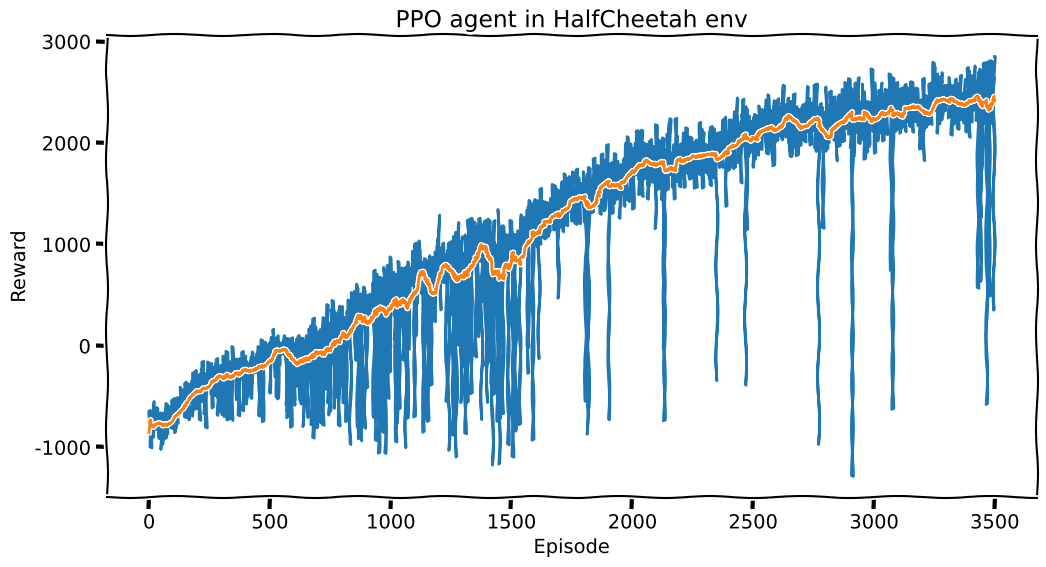

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [21]:
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config)

# We need to train for many more steps to achieve acceptable results compared to the last environment
actor_losses = []
critic_losses = []
rewards_history = []
sum_of_rewards = []

for episode in range(config.MAX_EPISODES):
    state, _ = env.reset()
    episode_reward = 0

    while True:
        # Select and execute action
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        # Store reward and accumulate episode reward
        agent.store_reward(reward)
        episode_reward += reward
        state = next_state

        if done or truncated:
            break

    # Update PPO agent after each episode
    actor_loss, critic_loss = agent.update()
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)
    rewards_history.append(episode_reward)

    # Print progress every 100 episodes
    if episode % 100 == 0:
        print(f'Episode {episode}: Reward = {episode_reward:.2f}, Actor Loss = {actor_loss:.6f}, Critic Loss = {critic_loss:.6f}')

env.close()

plot_rewards(rewards_history, show_result='PPO agent in HalfCheetah env')



# **Evaluating the PPO Agent in the HalfCheetah-v4 Environment**

In [22]:
# Create environment
%env MUJOCO_GL=egl
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
frames = []

done = False
total_reward = 0

# run the learned PPO agent to evaluate it
#TODO

state, _ = env.reset()
for _ in range(1000):
    # Get a deterministic action from the trained policy
    action = agent.select_action(state)

    # Step in the environment
    next_state, reward, done, truncated, _ = env.step(action)

    total_reward += reward

    # Render frame (already "rgb_array" mode) and store in our frames list
    frame = env.render()  # returns a numpy array
    frames.append(frame)

    state = next_state
    if done or truncated:
        break

env.close()
print(f"Total Reward: {total_reward}")

# Save frames as a video
video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)

# Display the video
show_video(video_path)

env: MUJOCO_GL=egl


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Total Reward: 2559.501580849602
